In [1]:
import os
from sklearn.model_selection import train_test_split
from Callbacks import Callbacks
from Config import Config
from DataLoader import DataLoader
from folder_defs import get_logdir, get_data_dir, get_image_dir
from train_model import train_model
from build_model import build_model
from save_model import save_model
from keras.models import load_model

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print('Beginning program')

# get config
config = Config().config
if config.change_bs == config.change_lr:
    raise Exception(f'[!] Error: config.change_bs and config.change_lr should'
                    f'be different bool values, but they are both'
                    f'{config.change_bs}. Set only one of them to True')

Beginning program
unparsed config options: ['-f', '/Users/Yacalis/Library/Jupyter/runtime/kernel-6355478c-4397-4036-87cc-e5a90e84af01.json']


In [3]:
# get constants
max_epochs = config.epochs
batch_size = config.batch_size
batch_size_increase_multiplier = 2
model_iter = 1
epoch_iter = 1

In [4]:
# get directories
log_dir = get_logdir(config)
data_dir = get_data_dir()
image_dir = get_image_dir()
print('log dir:', log_dir)
print('data dir:', data_dir)
print('image dir:', image_dir)

log dir: /Users/Yacalis/Projects/TensorFlow/cs274c-data/logs/0301_163609-changelr_False-changebs_True-batch_var
data dir: /Users/Yacalis/Projects/TensorFlow/cs274c-data/
image dir: /Users/Yacalis/Projects/TensorFlow/cs274c-data/Pictures/test/


In [5]:
# get callbacks
callbacks = Callbacks(config, log_dir).callbacks
print('callbacks:')
for callback in callbacks:
    print('\t', callback)

callbacks:


In [6]:
# get data
print('Loading data...')
dataloader = DataLoader(data_dir=data_dir, image_dir=image_dir)
x_data, y_data = dataloader.retrieve_data()

Loading data...
data file:  /Users/Yacalis/Projects/TensorFlow/cs274c-data/imdb.mat
number of records from data file:  460723
image dir:  /Users/Yacalis/Projects/TensorFlow/cs274c-data/Pictures/test/
	sub dirs:
		 00
shape of x_data:  (560, 228, 228, 3)


In [7]:
# get input dim
input_dim = x_data[0].shape
print('input dim: ', input_dim)
print('len of data: ', x_data.shape[0])

input dim:  (228, 228, 3)
len of data:  560


In [8]:
# split data into training and test sets - shuffles by default
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2)
num_train = int(x_train.shape[0] * 0.8)
print(f'Num training examples (excludes test and val): {num_train}')

Num training examples (excludes test and val): 358


In [9]:
# build model
model = build_model(input_dim, config)

Building model...
Finished building model
Compiling model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 56, 56, 96)        14208     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 11, 256)       1024      
_________________________________________________________________
conv2d_3 (Conv2

In [10]:
# save initial model
save_model(log_dir=log_dir, config=config, model=model)

Saving model...
Model saved


In [11]:
print(config.change_bs, config.change_lr)

True False


In [12]:
# set variables
val_loss = []
val_acc = []
loss = []
acc = []
lr = []

In [13]:
# train model
if config.change_lr:  # reduce_lr callback takes care of everything for us
    print('Will reduce learning rate during training, but not batch size')
    print('Training model...')
    model, history = train_model(model, x_train, y_train,
                                 batch_size, max_epochs, callbacks)
    val_loss += history.history['val_loss']
    val_acc += history.history['val_acc']
    loss += history.history['loss']
    acc += history.history['acc']
    lr += history.history['lr']
elif config.change_bs:  # need to manually stop and restart training
    print('Will reduce batch size during training, but not learning rate')
    # load model with its current weights
    model = load_model(os.path.join(log_dir, 'model.hdf5'))
    while max_epochs > epoch_iter:
        print(f'Currently at epoch {epoch_iter} of {max_epochs}')
        print(f'Batch size is {batch_size}')
        print(f'Training model {model_iter}...')
        epochs = max_epochs - epoch_iter + 1
        model, history = train_model(model, x_train, y_train,
                                     batch_size, epochs, callbacks)
        epoch_iter += len(history.epoch)
        val_loss += history.history['val_loss']
        val_acc += history.history['val_acc']
        loss += history.history['loss']
        acc += history.history['acc']
        model_iter += 1
        batch_size *= batch_size_increase_multiplier
        batch_size = batch_size if batch_size < num_train else num_train
        save_model(log_dir=log_dir, config=config, model=model)
else:
    raise Exception(f'[!] Error: config.change_bs and config.change_lr were'
                    f'both set to False -- please set one of them to True')
print('Completed training')

Will reduce batch size during training, but not learning rate
Currently at epoch 1 of 20
Batch size is 8
Training model 1...
Train on 358 samples, validate on 90 samples
Epoch 1/20
358/358 [==============================] - 35s 98ms/step - loss: 3.6275 - acc: 0.5950 - val_loss: 4.3589 - val_acc: 0.6889
Epoch 2/20
358/358 [==============================] - 44s 122ms/step - loss: 5.4131 - acc: 0.6034 - val_loss: 6.1532 - val_acc: 0.6111
Epoch 3/20
358/358 [==============================] - 42s 117ms/step - loss: 5.7434 - acc: 0.6061 - val_loss: 6.6206 - val_acc: 0.5556
Epoch 00003: early stopping
Saving model...
Model saved
Currently at epoch 4 of 20
Batch size is 16
Training model 2...
Train on 358 samples, validate on 90 samples
Epoch 1/17
358/358 [==============================] - 34s 94ms/step - loss: 5.9774 - acc: 0.6089 - val_loss: 5.0783 - val_acc: 0.6556
Epoch 2/17
358/358 [==============================] - 38s 105ms/step - loss: 5.0798 - acc: 0.6536 - val_loss: 6.3696 - val_acc:

In [17]:
# evaluate model
print('Calculating final score...')
score = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Final score:', score)

Calculating final score...
112/112 [==============================] - 3s 29ms/step
Final score: [7.0708136558532715, 0.5178571343421936]


In [18]:
# save finished model
save_model(log_dir=log_dir, config=config, model=model)
print('Completed program')

Saving model...
Model saved
Completed program


In [19]:
import matplotlib.pyplot as plt

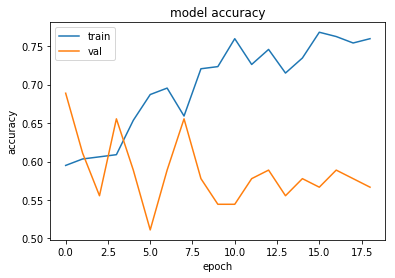

In [21]:
# summarize history for accuracy
plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

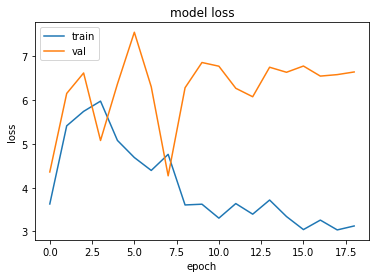

In [22]:
# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
int(x_train.shape[0] * 0.8)

358

In [24]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [25]:
val_loss

[4.358863470289442,
 6.153169886271159,
 6.620561430189345,
 5.07829508251614,
 6.369617218441434,
 7.551823520660401,
 6.304464160071479,
 4.271185217963325,
 6.283337042066786,
 6.8603268411424425,
 6.775761858622233,
 6.271294975280762,
 6.077858808305528,
 6.752355045742458,
 6.637114800347222,
 6.779670715332031,
 6.549660682678223,
 6.583470344543457,
 6.644146919250488]

In [16]:
if 8>= 9:
    print(True)

In [26]:
print(f'[!] Error: config.change_bs and config.change_lr were'
                        f'both set to False -- please set one of them to True')

[!] Error: config.change_bs and config.change_lr wereboth set to False -- please set one of them to True


In [1]:
from main import main

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
main()

Beginning program
unparsed config options: ['-f', '/Users/Yacalis/Library/Jupyter/runtime/kernel-6355478c-4397-4036-87cc-e5a90e84af01.json']
log dir: /Users/Yacalis/Projects/TensorFlow/cs274c-data/logs/0301_170310-changelr_False-changebs_True-batch_var
data dir: /Users/Yacalis/Projects/TensorFlow/cs274c-data/
image dir: /Users/Yacalis/Projects/TensorFlow/cs274c-data/Pictures/test/
callbacks:
Loading data...
data file:  /Users/Yacalis/Projects/TensorFlow/cs274c-data/imdb.mat
number of records from data file:  460723
image dir:  /Users/Yacalis/Projects/TensorFlow/cs274c-data/Pictures/test/
	sub dirs:
		 00
shape of x_data:  (560, 228, 228, 3)
input dim: (228, 228, 3)
len of data: 560
Num training examples (excludes test and val): 358
Building model...
Finished building model
Compiling model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 56, 56, 96)        14208     